# Working with Logan Search results with Python in Jupyter

About **Logan Search** - A k-mer search engine for all Sequence Read Archive public accessions available in Logan:

https://x.com/RayanChikhi/status/1855925390155370962    November 2024
>"A k-mer index for the entire SRA, finally."
	https://x.com/p_peterlongo/status/1855889588604031105
	>"There are 50 petabases of freely-available DNA sequencing data. We introduce "Logan Search" which allows you to search for any DNA sequence in minutes, bringing Earth’s largest genomic resource to your fingertips.
	🏔️ https://logan-search.org 🏔️"
	>"Under the hood, we built a 1 petabyte k-mer index for all 27 million sequencing datasets in the SRA up to 12-2023."
	>"Logan Search transforms your query🧬 to its k-mers🔢 (k=31), and in the time it takes to brew a coffee, it will retrieve every dataset containing your k-mers. It’s the only service working at this scale"

https://bsky.app/profile/rayanchikhi.bsky.social/post/3lhc2bxavas2h  February 2025
>"We have updated all Logan contigs, now at version 1.1! Contiguity has been much improved (2x) and a duplicated k-mers bug has been fixed. More information and changelog here:"
>"For more context: Logan is a collection of all public sequencing data (until end of 2023) assembled into contigs. It is freely hosted on the cloud, and contains hundreds of terabytes of valuable genomic data: https://github.com/IndexThePlanet/Logan "


Therefore, the results give you information for a single search sequence across the entire [Sequence Read Archive (SRA)](https://www.ncbi.nlm.nih.gov/sra) detailing datasets where that dataset occurs.

**The web interface the results are presented in let's you easly examine things, such as a bar plot with the count the organims represented by the datasets, available via the 'Plot' button.** However, after working with Logan Search some, you may want to combine results for different sequences to see if you can learn something. The web interface they provide doesn't seem to allow this, yet with a Python/Jupyter combination we can do this easily.  
This notebook begins to illustrate that.

Demonstration Example:

**QUESTION**: Can you use multiple sets of query results to get information about splicing isoforms for a gene?

Case study:

##### *USP7* transcript isoforms

*USP7* was among the additional 35 genes indicated to have alternate splicing variant isoforms with diagnostic properties in [Blakes et al 2022 'A systematic analysis of splicing variants identifies new diagnoses in the 100,000 Genomes Project'](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-022-01087-x). The 35 was beyond any participants whose case was already solved through 100,000 Genomes Project, that the study also included.

The transcript table for *USP7* can be seen by going to [here]( https://useast.ensembl.org/Homo_sapiens/Transcript/Summary?db=core;g=ENSG00000187555;r=16:8895045-8956380;t=ENST00000344836) and clicking on the button 'Show transcript table' to the right of the 'Gene' line, which is below the 'About this transcript' line. That will toggle on displaying the transcript table.

The first line in that table shows the the MANE Select transcript with a Transcript Support Level (TSL) rating of 1.  
You can read about [Transcript Support Level (TSL) flags here](https://useast.ensembl.org/info/genome/genebuild/transcript_quality_tags.html).
Note that several lower in the table retain and intron and only have a TSL rating of 4.  
Can we see less support for those among datasets that include human sequences?



-----

#### Preparation

Several Logan Search queries were done with data for the MANE Select transcript as well as the TSL-rated [ENST00000567329 (USP7-217)](https://useast.ensembl.org/Homo_sapiens/Transcript/Exons?db=core;g=ENSG00000187555;r=16:8895045-8956380;t=ENST00000567329).

The notebook assumes data is placed in a directory named `logan_search_results`; however, you can edit the code below

At this time it is one directory per related gene.

#### Reading in the results for several queries

Run the code in the next cell assigning the settings to match the set-up preparation performed and to bring in the results data to the active namespace:

In [1]:
results_dir = "/home/jovyan/logan_search_results/"
consistent_part_of_file_name_suffix = "_31mer_"

import os
import fnmatch
import pandas as pd

def extract_tags_from_filename(filename):
    '''
    extract tag labels from file names

    return the tag label
    '''
    first_part = filename.split(consistent_part_of_file_name_suffix,1)[0]
    all_but_first_part_of_remainder_as_list = first_part.split("_")[1:]
    return "_".join(all_but_first_part_of_remainder_as_list)
    
matched_filenames = []
file_tags_per_file = []
dfs = []
for file in os.listdir(results_dir):
    if fnmatch.fnmatch(file, '*.tsv'):
        matched_filenames.append(file)
        file_tags_per_file.append(extract_tags_from_filename(file))
        dfs.append(pd.read_csv(results_dir + file, sep="\t"))

# provide feedback about what was read in
max_filename_length = max(len(filename) for filename in matched_filenames)
for filename, df in zip(matched_filenames, dfs): 
    print(f'from {filename}:{" " * (max_filename_length - len(filename))} {len(df):>6} rows read in')

#print(file_tags_per_file) # FOR DEBUGGING, uncomment
#print(matched_filenames) # FOR DEBUGGING, uncomment
gene_name = file_tags_per_file[0].split("_",1)[0]
# make tuples of tag labels and corresponding dataframes
tags_and_dataframes = list(zip(file_tags_per_file, dfs)) # tags are first in each two-item tuple, the dataframe is second
# make dictionary of tuples of tag labels and corresponding dataframes, integers will be the keys with the tuples as values
tags_and_dataframes_dict = dict(zip(range(len(file_tags_per_file)), zip(file_tags_per_file, dfs))) # integers ('index') are keys with tags are first in each two-item tuple, the dataframe is second

from human_USP7_TSL4_altSJ_31mer_logan_results.tsv:  19997 rows read in
from human_USP7_TSL4_SJ_31mer_logan_results.tsv:     19998 rows read in
from human_USP7_SJ_14n15_31mer_logan_results.tsv:    19999 rows read in
from human_USP7_SJ_34_31mer_logan_results.tsv:       19997 rows read in


I had it print in the number of rows read from the results files.

-------

**Aside**:

Since I printed the number of rows read in from the Logan Search results files, I'd like to discuss what it shoed for a minute.

Remember the Logan Search says, "The top 20k hits are returned." So I'm not quite sure why it isn't quite 20K for any one of these and why the total numbers aren't all equal but slightly less than one another, save the two that are 19997. Does this point to a data munging issue?

I don't think so because I see similar when the working directory is `/home/jovyan/logan_search_results` and I run the following code:

```bash
!wc -l human_USP7_SJ_14n15_31mer_logan_results.tsv
!wc -l human_USP7_SJ_34_31mer_logan_results.tsv
!wc -l human_USP7_TSL4_altSJ_31mer_logan_results.tsv
!wc -l human_USP7_TSL4_SJ_31mer_logan_results.tsv
```

Gives:

```text
19999 human_USP7_SJ_14n15_31mer_logan_results.tsv
19997 human_USP7_SJ_34_31mer_logan_results.tsv
19997 human_USP7_TSL4_altSJ_31mer_logan_results.tsv
19998 human_USP7_TSL4_SJ_31mer_logan_results.tsv
```

So it isn't Pandas. But why are numbers the same as the values for 'rows read in'? Accounting for the header line should add one to all the values seen for 'rows read in' relative to when using bash to print number of lines. Indeed, when I did `!head human_USP7_SJ_14n15_31mer_logan_results.tsv > human_USP7_test.tsv` and then read in `human_USP7_test.tsv` it says it read in 9 rows and `!wc -l human_USP7_test.tsv` gives `10` because it includes the header. So that makes sense. (But looking at it in Jupyter's text editor, I see 20 lines of content and one extra line that looks empty and this agrees with what I saw locally in my text editor.) But why doesn't `!wc -l` with the actual full `.tsv`s make accurate sense relative to Pandas?  
None of this changes the overall conclusions here, but it is midly concerning to see things not quite adding up and all being equal.

I did quite a lot to investigate this further but other than different type of line endings, I'm not seeing anything to cause this one-off issue. (Or even why `wc -l` disagrees with my text editor while being one-off from Pandas.)

`-------------------`end of **Aside**`-------------------`end of **Aside**`-------------------`
____

#### Plotting the results of the individual queries in a single plot

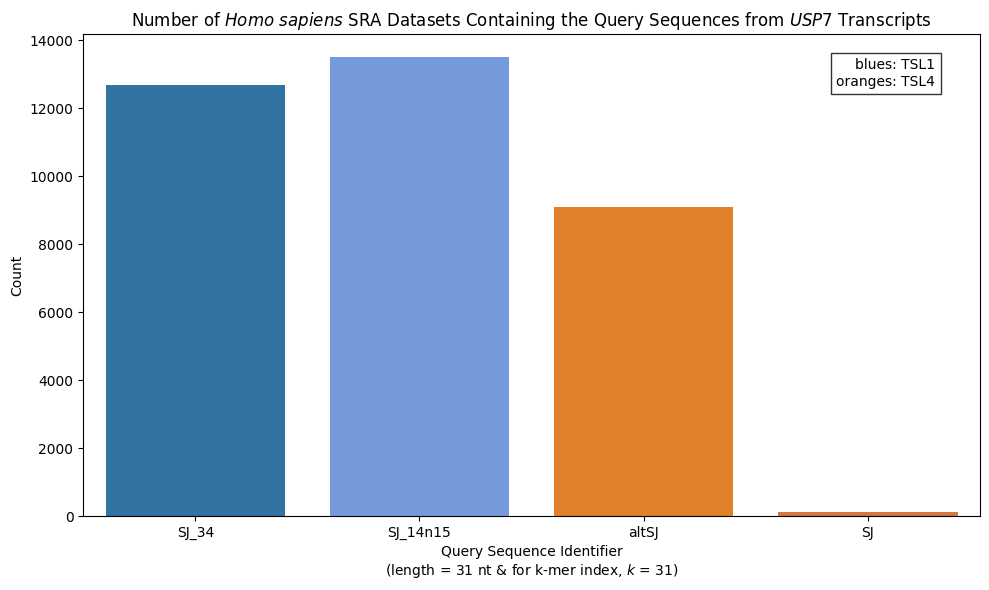

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def simplifytags(tag):
    '''
    remove some of the consistent part at the start of the tag
    '''
    special_additional_name_part_to_not_include = "TSL4_"
    if special_additional_name_part_to_not_include in tag:
        new_tag = tag.split(special_additional_name_part_to_not_include,1)[1]
    else:
        new_tag = tag.split("_",1)[1]
    return new_tag

def plot_homo_sapiens_counts(dfs, labels=None, palette='husl', order=None, legend_text=None):
    """
    Plot the count of 'Homo sapiens' in the 'organism' column for multiple dataframes.
    
    Parameters:
    dfs (list): List of pandas DataFrames
    labels (list): Optional list of labels for each DataFrame. If None, will use index numbers
    palette (str or list): Color palette to use
    order (list): Optional list specifying the desired order of labels
    legend_text (str): Optional custom legend text
    """
    # Calculate counts for each dataframe
    counts = [df['organism'].value_counts()['Homo sapiens'] if 'Homo sapiens' in df['organism'].values else 0 
             for df in dfs]
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Dataset': labels if labels else [f'Dataset {i+1}' for i in range(len(dfs))],
        'Count': counts
    })
    
    # If order is specified, convert Dataset to ordered categorical
    if order is not None:
        plot_df['Dataset'] = pd.Categorical(plot_df['Dataset'], categories=order, ordered=True)
        
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_df, x='Dataset', y='Count', hue='Dataset', palette=palette, legend=False)
    #print(plot_df) #Uncomment this to show the counts!
    
    # Customize the plot
    plt.title(('Number of $\mathit{Homo\ sapiens}$ SRA Datasets Containing the '
           'Query Sequences from $\mathit{' + gene_name + '}$ Transcripts'))
    #plt.xticks(rotation=45)
    plt.xlabel('Query Sequence Identifier\n(length = 31 nt & for k-mer index, $\mathit{k}$ = 31)')
    plt.ylabel('Count')

    if legend_text:
        # Position the text in the upper right corner
        # Adjust the x and y values (0.95, 0.95) to change position
        ax = plt.gca()
        plt.figtext(0.95, 0.95, legend_text, 
                   transform=ax.transAxes,
                   horizontalalignment='right',
                   verticalalignment='top',
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Example usage:
labels = [simplifytags(x) for x in file_tags_per_file]
desired_order = [labels[3],labels[2],labels[0], labels[1]]  # Replace with your actual k-mer names in desired order
#colors = ['#1f77b4','#ff7f0e', '#2ca02c', '#d62728']
colors = ['#1f77b4', 'cornflowerblue','#ff7f0e', '#ef6f2e']
legend_text = "blues: TSL1\noranges: TSL4"
plot_homo_sapiens_counts(dfs, labels, palette=colors, order=desired_order,legend_text=legend_text)
plt.show()

### Results

Clearly the well-supported USP7 splice junctions ([Transcript Support Level (TSL)](https://useast.ensembl.org/info/genome/genebuild/transcript_quality_tags.html) 1) from the MANE Select transcript  indicated with blue colors are more represented in SRA data than those of the orange splice junctions which come from a [TSL4](https://useast.ensembl.org/info/genome/genebuild/transcript_quality_tags.html)-rated transcript.   
Note the k-mer to represent the [TSL4](https://useast.ensembl.org/info/genome/genebuild/transcript_quality_tags.html)-rated splice junction differs between the two 'orange' bar plots in that three on one side of the splice junction were removed to make `altSJ` while three additional were added upstream of the splice junction to still result in a *k*= 31 k-mer. **Why they differ so dramatically in number of human hits, 9096 vs. 117, is not clear then given that assumingly small difference.** Was there some mundane assembly issue or 'swamping' by matches to another organism?

'Competing out' looks possible here for the query sequence `SJ`. You'll recall above where 'rows read in' was shown that all the results `.tsv` files had roughly the same content. Investigating the results in `human_USP7_TSL4_SJ_31mer_logan_results.tsv` in the Logan Search's web interface had already indicated a lot of hits to monkey. So those monkey datasets seem to fill up the SRA datasets reported first?   
Can we show the many, many hits to monkey here? 

Running this next cell illustrates that I see a lot of that query sequence in  *Macaca mulatta* and *Macaca fascicularis* in the results in `human_USP7_TSL4_SJ_31mer_logan_results.tsv`:

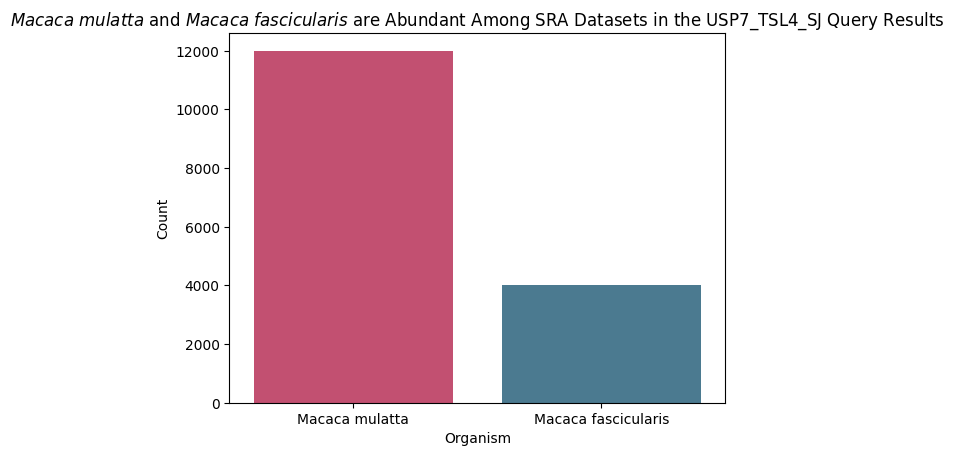

In [3]:
# Look at *Macaca mulatta* and *Macaca fascicularis* in data for `USP7_TSL4_SJ`
import seaborn as sns
SJ_df = tags_and_dataframes_dict[1][1]

import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame
filtered_df = SJ_df[SJ_df['organism'].isin(['Macaca mulatta', 'Macaca fascicularis'])]

# Count occurrences of each organism
organism_counts = filtered_df['organism'].value_counts()

# Create the bar plot using seaborn
#sns.barplot(x=organism_counts.index, y=organism_counts, hue=organism_counts.index, palette = sns.color_palette("Set2",2))
#sns.barplot(x=organism_counts.index, y=organism_counts, hue=organism_counts.index, palette = sns.diverging_palette(220, 20, n=2))
sns.barplot(x=organism_counts.index, y=organism_counts, hue=organism_counts.index, palette = sns.diverging_palette(0, 230, n=2))

plt.xlabel('Organism')
plt.ylabel('Count')
plt.title('$\mathit{Macaca\ mulatta}$ and $\mathit{Macaca\ fascicularis}$ are Abundant Among SRA Datasets in the USP7_TSL4_SJ Query Results')
plt.show()

That search query sequence must match well to a lot of *Macaca mulatta* and *Macaca fascicularis*, and so those come up first, it seems. Don't know why it would favor those, however, that is what it seems to do.

-----

Enjoy!